# 重なった手書き数字の識別 - CNN & (SGD, Adam) & BN (PyTorch) -

## 0.ライブラリのimport

In [82]:
import torch as torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
from torchsummary import summary
from pylab import rcParams

## 1.datasetの準備

In [83]:
# MNISTの画像とラベルの準備
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784')
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
    
X, T = mnist.data.reshape(-1, 28, 28), mnist.target.astype(np.int32)

In [84]:
# 2つの画像を重ね合わせる。100次元(→55次元にもできる)クラスの分類。
# 別の番号の画像を組み合わせることで、かなりデータを増やすこともできる。
n = len(X) // 2
T_100 = np.zeros(n, dtype=np.int)
for i in range(n):
    X[i] = np.maximum(X[i], X[i + n])
    max_i, min_i = max(T[i], T[i + n]), min(T[i], T[i + n])
    T_100[i]  = min_i * 10 + max_i
    
X = X[:n]
T = T_100

In [85]:
# train test に分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

In [86]:
# サイズの確認。
print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)

(28000, 28, 28)
(7000, 28, 28)
(28000,)
(7000,)


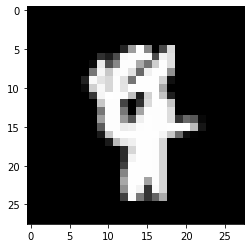


Label:  7 9
----------------------------


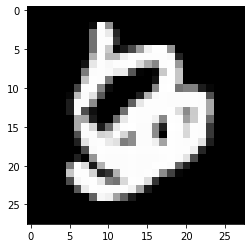

Label:  3 6
----------------------------


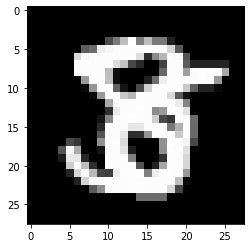

Label:  3 8
----------------------------


In [87]:
# サンプル画像を表示する。2つの画像が重なっている。
plt.gray()
for i in range(3):
    plt.imshow(x_train[i])
    plt.show()
    label = ' '.join(['0'] * (2 - len(list(str(t_train[i])))) + list(str(t_train[i]))) 
    print('Label: ', label)
    print('----------------------------')

In [88]:
class MNISTdatasets(torch.utils.data.Dataset):
    def __init__(self, data, label, transform = None):
        self.transform = transform
        self.data = data
        self.label = label
        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [89]:
transform = torchvision.transforms.ToTensor() #dataは十分あったので、data_augumentationは行わなかった。
train_dataset = MNISTdatasets(x_train, t_train, transform)
test_dataset = MNISTdatasets(x_test, t_test, transform)

In [90]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                          num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=4)

## 2.モデルの作成

In [91]:
num_classes = 100#出力クラス数

class AlexNet(nn.Module):
    
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
        )

    def conv_block_pooling(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.block1 = self.conv_block(1,96)
        self.block2 = self.conv_block_pooling(96,256)
        self.block3 = self.conv_block(256,384)
        self.block4 = self.conv_block_pooling(384,384)
        self.block5 = self.conv_block(384,256)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*7*7,1048),
            nn.Dropout(p=0.5),
            nn.Linear(1048,1048),
            nn.Linear(1048,num_classes),
        )

    def forward(self, x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x = x.view(x.size(0),256*7*7)
        x = self.classifier(x)
        return x
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [92]:
net = AlexNet(num_classes).to(device)

In [93]:
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]             960
       BatchNorm2d-2           [-1, 96, 28, 28]             192
              ReLU-3           [-1, 96, 28, 28]               0
            Conv2d-4          [-1, 256, 28, 28]         221,440
       BatchNorm2d-5          [-1, 256, 28, 28]             512
              ReLU-6          [-1, 256, 28, 28]               0
         MaxPool2d-7          [-1, 256, 14, 14]               0
            Conv2d-8          [-1, 384, 14, 14]         885,120
       BatchNorm2d-9          [-1, 384, 14, 14]             768
             ReLU-10          [-1, 384, 14, 14]               0
           Conv2d-11          [-1, 384, 14, 14]       1,327,488
      BatchNorm2d-12          [-1, 384, 14, 14]             768
             ReLU-13          [-1, 384, 14, 14]               0
        MaxPool2d-14            [-1, 38

## 3.SGD

### 3-1.モデルの学習(SGD)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [95]:
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    i = 0
    
    net.train() 
    for (images, labels) in tqdm_notebook(train_loader):
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad() 
        outputs = net(images.float()) 
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item() 
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset) 
    avg_train_acc = train_acc / len(train_loader.dataset) 
    
    net.eval() 
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
    
        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

/home/yamaguchishohei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Epoch [1/20], Loss: 0.0265, val_loss: 0.0193, val_acc: 0.6851



Epoch [2/20], Loss: 0.0112, val_loss: 0.0099, val_acc: 0.8120



Epoch [3/20], Loss: 0.0081, val_loss: 0.0104, val_acc: 0.7960



Epoch [4/20], Loss: 0.0064, val_loss: 0.0065, val_acc: 0.8707



Epoch [5/20], Loss: 0.0055, val_loss: 0.0078, val_acc: 0.8469



Epoch [6/20], Loss: 0.0047, val_loss: 0.0061, val_acc: 0.8794



Epoch [7/20], Loss: 0.0039, val_loss: 0.0067, val_acc: 0.8753



Epoch [8/20], Loss: 0.0035, val_loss: 0.0064, val_acc: 0.8794



Epoch [9/20], Loss: 0.0030, val_loss: 0.0066, val_acc: 0.8777



Epoch [10/20], Loss: 0.0026, val_loss: 0.0057, val_acc: 0.8956



Epoch [11/20], Loss: 0.0022, val_loss: 0.0059, val_acc: 0.8907



Epoch [12/20], Loss: 0.0020, val_loss: 0.0071, val_acc: 0.8767



Epoch [13/20], Loss: 0.0017, val_loss: 0.0063, val_acc: 0.8894



Epoch [14/20], Loss: 0.0016, val_loss: 0.0067, val_acc: 0.8854



Epoch [15/20], Loss: 0.0014, val_loss: 0.0066, val_acc: 0.8929



Epoch [16/20], Loss: 0.0013, val_loss: 0.0068, val_acc: 0.8919



Epoch [17/20], Loss: 0.0012, val_loss: 0.0069, val_acc: 0.8861



Epoch [18/20], Loss: 0.0009, val_loss: 0.0074, val_acc: 0.8827



Epoch [19/20], Loss: 0.0010, val_loss: 0.0069, val_acc: 0.8953



Epoch [20/20], Loss: 0.0008, val_loss: 0.0065, val_acc: 0.8904


### 3-2.学習結果の表示(SGD)

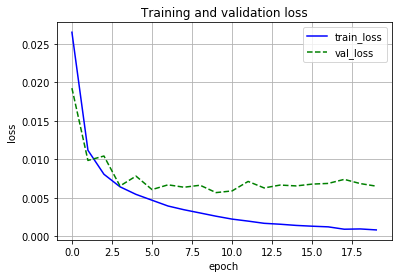

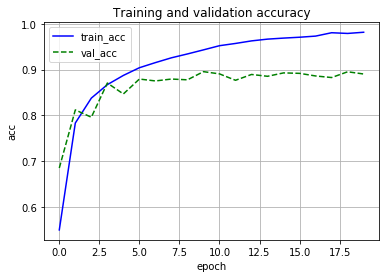

In [96]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

#### 考察①
#### 全結合では、4~5割程の制度であったが、畳み込むことで精度が大幅に伸びた。ここまで精度が伸びることに驚いた。

#### 考察②
#### 何度か試すと、たまに、train_loss　の方が、 val_loss　よりも大きくなることに驚いた。
#### ネット検索してみたところ、 trainには、Dropuoutが入っているのが原因だという結論になり、納得がいった。

## 4.Adam

### 4-1.モデルの学習(Adam)

In [98]:
net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

### 4-2.学習結果の表示(Adam)

In [99]:
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    i = 0
    
    net.train() 
    for (images, labels) in tqdm_notebook(train_loader):
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad() 
        outputs = net(images.float()) 
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item() 
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset) 
    avg_train_acc = train_acc / len(train_loader.dataset) 
    
    net.eval() 
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
    
        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

/home/yamaguchishohei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Epoch [1/20], Loss: 0.0533, val_loss: 0.0187, val_acc: 0.6493



Epoch [2/20], Loss: 0.0166, val_loss: 0.0131, val_acc: 0.7504



Epoch [3/20], Loss: 0.0110, val_loss: 0.0112, val_acc: 0.7839



Epoch [4/20], Loss: 0.0089, val_loss: 0.0077, val_acc: 0.8454



Epoch [5/20], Loss: 0.0078, val_loss: 0.0090, val_acc: 0.8197



Epoch [6/20], Loss: 0.0068, val_loss: 0.0068, val_acc: 0.8680



Epoch [7/20], Loss: 0.0061, val_loss: 0.0071, val_acc: 0.8571



Epoch [8/20], Loss: 0.0056, val_loss: 0.0075, val_acc: 0.8606



Epoch [9/20], Loss: 0.0051, val_loss: 0.0072, val_acc: 0.8597



Epoch [10/20], Loss: 0.0049, val_loss: 0.0071, val_acc: 0.8676



Epoch [11/20], Loss: 0.0045, val_loss: 0.0066, val_acc: 0.8807



Epoch [12/20], Loss: 0.0043, val_loss: 0.0085, val_acc: 0.8543



Epoch [13/20], Loss: 0.0042, val_loss: 0.0077, val_acc: 0.8717



Epoch [14/20], Loss: 0.0040, val_loss: 0.0078, val_acc: 0.8673



Epoch [15/20], Loss: 0.0038, val_loss: 0.0090, val_acc: 0.8737



Epoch [16/20], Loss: 0.0038, val_loss: 0.0082, val_acc: 0.8731



Epoch [17/20], Loss: 0.0032, val_loss: 0.0077, val_acc: 0.8793



Epoch [18/20], Loss: 0.0033, val_loss: 0.0073, val_acc: 0.8816



Epoch [19/20], Loss: 0.0033, val_loss: 0.0086, val_acc: 0.8704



Epoch [20/20], Loss: 0.0032, val_loss: 0.0080, val_acc: 0.8781


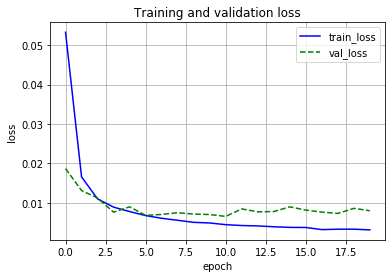

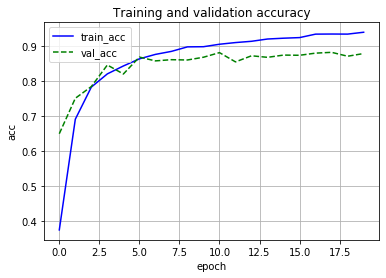

In [100]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

#### 考察③
#### Adamの方が、SGDよりもやや精度が低くなった。ハイパーパラメーターの調整でもう少し伸びるかもしれない。